In [98]:
# 数据处理库
import pandas as pd
import numpy as np
import datetime as dt

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns

# 机器学习库
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [99]:
fileNameStr='Online Retail.xlsx'
df = pd.read_excel(fileNameStr,sheet_name='Online Retail')
#看看前五行
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [100]:
#可以看出Description和CustomerID有缺失值
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [101]:
#看看缺失值的分布情况
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [102]:
#CustomerID对此次数据分析至关重要，因此清理掉为空的行
df= df.dropna(subset=['CustomerID'])
df.isnull().sum().sum()

0

In [103]:
# 删除重复行
print("原始数据中共有{}行重复行".format(df.duplicated().sum()))
df = df.drop_duplicates()
print("删除重复值后共有{}行重复行".format(df.duplicated().sum()))

原始数据中共有5225行重复行
删除重复值后共有0行重复行


In [104]:
#unitprice的min是0，quantity的最小值是负数
df.describe()

,Quantity,UnitPrice,CustomerID
count,401604.000000,401604.000000,401604.000000
mean,12.183273,3.474064,15281.160818
std,250.283037,69.764035,1714.006089
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13939.000000
50%,5.000000,1.950000,15145.000000
75%,12.000000,3.750000,16784.000000
max,80995.000000,38970.000000,18287.000000


In [105]:
#取quantity>0和unitprice>0的数据
df=df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.describe() 

,Quantity,UnitPrice,CustomerID
count,392692.000000,392692.000000,392692.000000
mean,13.119702,3.125914,15287.843865
std,180.492832,22.241836,1713.539549
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


In [106]:
df.shape

(392692, 8)

# 同期群分析
对于同期群分析，需要创建一些标签：
- 发票日期：单笔交易年和月的字符串表示。
- 同期群：客户首次购买的年份和月份的字符串表示形式。 
- 同期指数：表示客户的生命周期。 该数字表示自首次购买以来经过的月数。

In [107]:
#把日期设置为1号方便按照月份分组
def get_month(x) : 
    return dt.datetime(x.year,x.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
#把用户按最小的购物月份分组
grouped = df.groupby('CustomerID')['InvoiceMonth']
df['CohortMonth'] = grouped.transform('min')
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-01,2011-08-01
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-01,2011-08-01
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-01,2011-08-01
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France,2011-12-01,2011-08-01


In [108]:
def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(df,'InvoiceMonth')
cohort_year,cohort_month,_ = get_month_int(df,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 
#计算周期是一个月
df['CohortIndex'] = year_diff * 12 + month_diff

In [109]:
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
# 算一下每个组每个月独立用户的数量
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
# 计算留存率
cohort_size = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_size,axis=0) #axis=0 或者 axis='rows' 表示跨行计算
retention.round(3) * 100 #以百分比的形式呈现

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02-01,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03-01,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04-01,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05-01,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


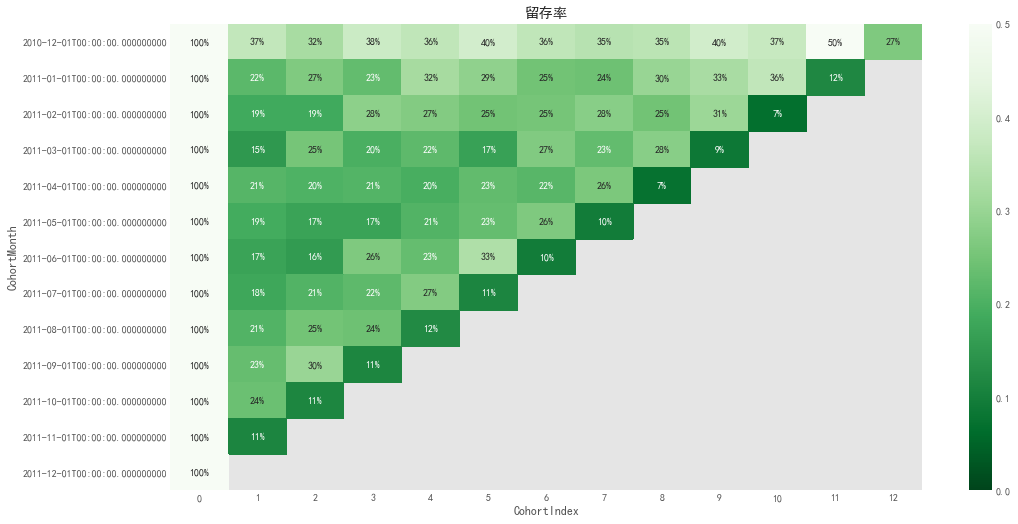

In [111]:
#绘制热力图
plt.figure(figsize=(15, 8))
plt.title('留存率')
plt.rcParams['font.sans-serif']=['SimHei']
sns.heatmap(data=retention,annot = True,fmt = '.0%',vmin = 0.0,vmax = 0.5,cmap="Greens_r")
plt.show()

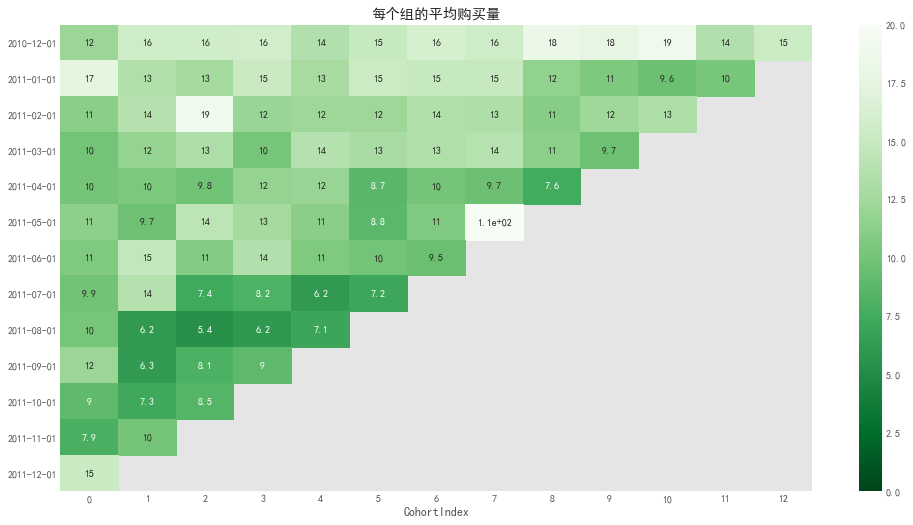

In [112]:
#每个组的平均购买数量
grouping = df.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

#绘制热力图
plt.figure(figsize=(15, 8))
plt.title('每个组的平均购买量')
sns.heatmap(data=average_quantity,annot = True,vmin = 0.0,vmax =20,cmap="Greens_r")
plt.show()

## RFM模型
> Recency   &emsp; 最后一次消费距离现在时间距离  &emsp; R越小越好<br/>
> Frequency   &emsp; 消费频率  &emsp; F越大越好<br/>
> Monetary  &emsp; 消费金额  &emsp; M越大越好

In [113]:
#添加新列计算销售总额 
df['TotalSum'] = df['UnitPrice']* df['Quantity']

print('发票最小日期:',df.InvoiceDate.dt.date.min(),'发票最大日期:',
       df.InvoiceDate.dt.date.max())

df.head()

发票最小日期: 2010-12-01 发票最大日期: 2011-12-09


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0,20.34


In [114]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

In [115]:
# 计算 RFM 矩阵
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (snapshot_date - x.max()).days,
                                      'InvoiceNo':'count','TotalSum': 'sum'})

#重命名
rfm.rename(columns={'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalSum':'MonetaryValue'},
           inplace= True)

rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


> 由于每个公司都希望自己的客户是最近的客户，因此对最近最活跃的客户的评价要优于其他的客户
给“频率”和“花费”更高的标签打分，因为公司希望客户花更多的钱并更频繁地拜访。

In [116]:
#计算RFM值
r_labels =range(4,0,-1)
f_labels=range(1,5)
m_labels=range(1,5)
r_quartiles = pd.qcut(rfm['Recency'], q=4, labels = r_labels)
f_quartiles = pd.qcut(rfm['Frequency'],q=4, labels = f_labels)
m_quartiles = pd.qcut(rfm['MonetaryValue'],q=4,labels = m_labels)
rfm = rfm.assign(R=r_quartiles,F=f_quartiles,M=m_quartiles)

def add_rfm(x) : 
    return str(x['R']) + str(x['F']) + str(x['M'])

rfm['RFM_Segment'] = rfm.apply(add_rfm,axis=1 )
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
#RFM的值越大越好
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6.0
12347.0,2,182,4310.00,4,4,4,444,12.0
12348.0,75,31,1797.24,2,2,4,224,8.0
12349.0,19,73,1757.55,3,3,4,334,10.0
12350.0,310,17,334.40,1,1,2,112,4.0


In [117]:
#按照RFM_Segment分组的大小从大到小排序
rfm.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
444    450
111    381
344    217
122    206
211    179
dtype: int64

In [118]:
#RFM_segment最小值"111"的前五条
rfm[rfm['RFM_Segment']=='111'].head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12353.0,204,4,89.00,1,1,1,111,3.0
12361.0,287,10,189.90,1,1,1,111,3.0
12401.0,303,5,84.30,1,1,1,111,3.0
12402.0,323,11,225.60,1,1,1,111,3.0
12441.0,367,11,173.55,1,1,1,111,3.0


In [119]:
#按照RFM_Score分组聚合
rfm.groupby('RFM_Score').agg({'Recency': 'mean','Frequency': 'mean',
                             'MonetaryValue': ['mean', 'count'] }).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3.0         260.7       8.2         157.4   381
4.0         177.2      13.6         240.0   388
5.0         152.9      21.2         366.6   518
6.0          95.9      27.9         820.8   457
7.0          79.6      38.0         758.1   463
8.0          64.1      56.0         987.3   454
9.0          45.9      78.7        1795.1   414
10.0         32.4     110.5        2056.4   426
11.0         21.3     186.9        4062.0   387
12.0          7.2     367.8        9285.9   450

In [120]:
#按照RFM_Score的分值高低对用户贴标签:黄金（大于9），白银(5到9之间)，青铜(小于5)
def segments(df):
    if df['RFM_Score'] > 9 :
        return 'Gold'
    elif (df['RFM_Score'] > 5) and (df['RFM_Score'] <= 9 ):
        return 'Silver'
    else:  
        return 'Bronze'

rfm['General_Segment'] = rfm.apply(segments,axis=1)

rfm.groupby('General_Segment').agg({'Recency':'mean','Frequency':'mean',
                                    'MonetaryValue':['mean','count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            192.2      15.1         266.5  1287
Gold               20.1     225.6        5246.8  1263
Silver             72.0      49.4        1072.4  1788

## 利用K-Means进行聚类预测
首要要保证变量具有以下特点：

- 变量对称分布（不偏斜）
- 变量具有相同平均值
- 变量具有相同方差

In [121]:
rfm_rfm = rfm[['Recency','Frequency','MonetaryValue']]
rfm_rfm.describe()
#属性单位不同造成的数值差异过大会造成计算距离时的权重分布不均衡，不能反映实际情况，所以要对数据进行标准化处理
#存在的问题：均值和方差是不相等的
#解决方法：sklearn标准化一下

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,90.523744,2048.688081
std,100.014169,225.506968,8985.230220
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,306.482500
50%,51.000000,41.000000,668.570000
75%,142.000000,98.000000,1660.597500
max,374.000000,7676.000000,280206.020000


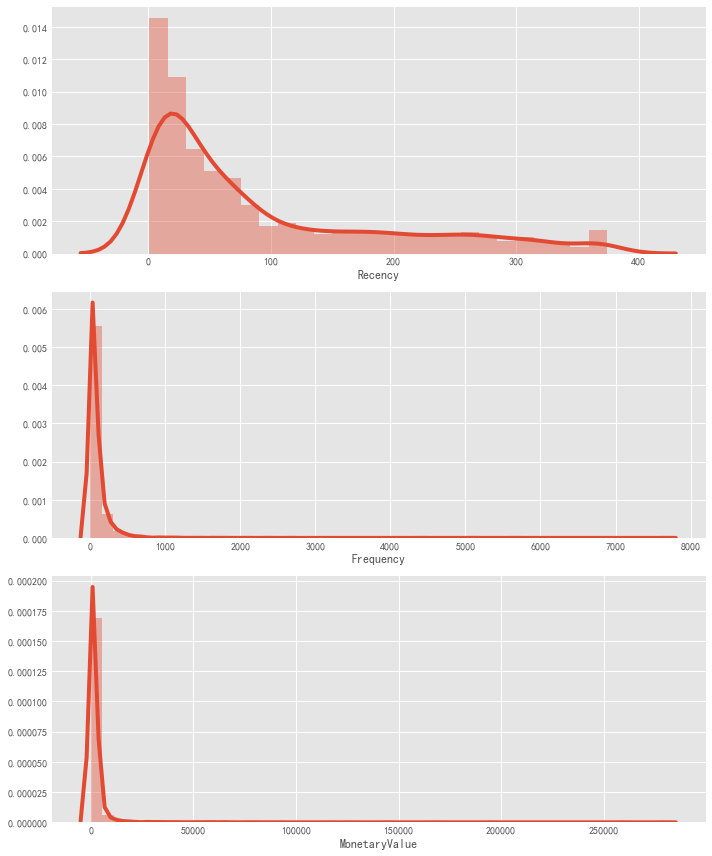

In [122]:
# 绘图看看RFM分布情况
fig,ax = plt.subplots(figsize=(10, 12))
plt.grid(alpha=0.4)
plt.subplot(3, 1, 1); 
sns.distplot(rfm.Recency, label = 'Recency')
plt.subplot(3, 1, 2); 
sns.distplot(rfm.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); 
sns.distplot(rfm.MonetaryValue, label = 'Monetary Value')
plt.tight_layout()
plt.show()

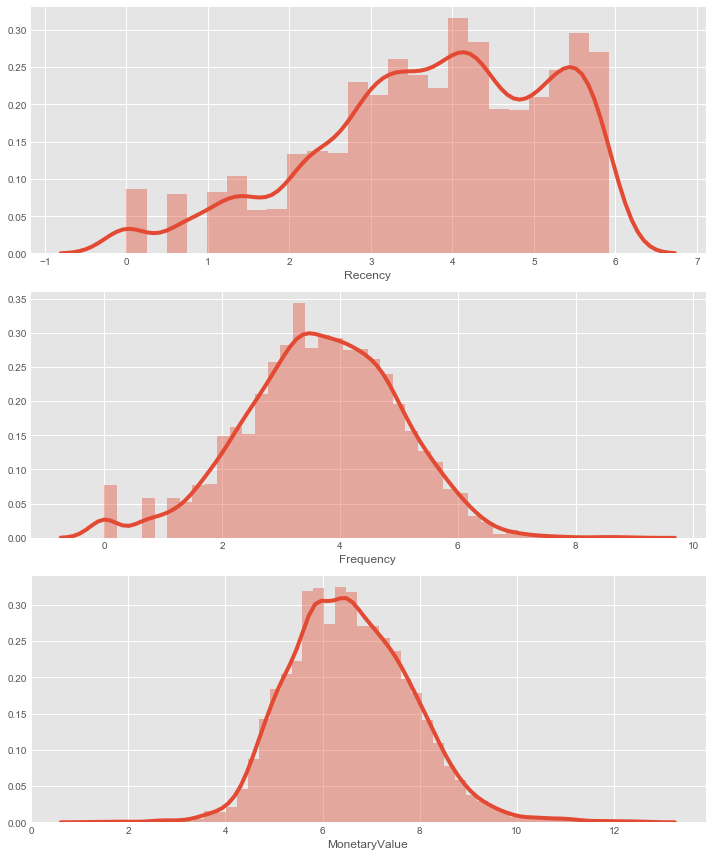

In [123]:
#数据大部分都聚集在了一起，并且有一些非常离散的极端值数据，使用log函数对数据进行处理，让其分布的更加均匀
rfm_log = rfm[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log, axis = 1).round(3)

#再看看分布情况
fig,ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); 
sns.distplot(rfm_log.Recency, label = 'Recency')
plt.subplot(3, 1, 2); 
sns.distplot(rfm_log.Frequency, label = 'Frequency')
plt.subplot(3, 1, 3); 
sns.distplot(rfm_log.MonetaryValue, label = 'Monetary Value')
plt.style.use('seaborn-white')
plt.tight_layout()
plt.show()

## 聚类处理步骤
- 数据预处理
- 确定聚类簇数量
- 聚类
- 分析每个类的RFM

In [124]:
#标准化/归一化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(rfm_log)

rfm_normalized= scaler.transform(rfm_log)

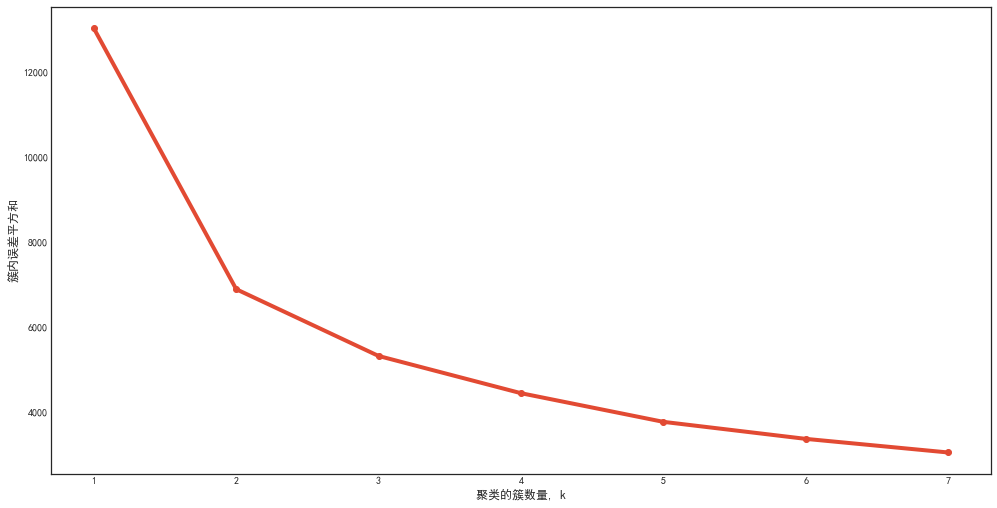

In [125]:
from sklearn.cluster import KMeans

#用肘方法确定簇数量
ks = range(1,8)
inertias=[]
for k in ks :#k取值7，做kmeans聚类，看不同k值对应的簇内误差平方和
    kc = KMeans(n_clusters=k,random_state=1)
    kc.fit(rfm_normalized)
    inertias.append(kc.inertia_)#inertia簇内误差平方和，值越小越好，越小表示样本在类间的分布越集中

# Plot ks vs inertias
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(ks, inertias, '-o')
plt.rcParams['font.sans-serif']=['SimHei']
plt.xlabel('聚类的簇数量, k')
plt.ylabel('簇内误差平方和')
plt.xticks(ks)
plt.show()

In [126]:
#聚类（选择3）
kc = KMeans(n_clusters= 3, random_state=1)
kc.fit(rfm_normalized)

cluster_labels = kc.labels_

#加一列表示是哪个簇
rfm_rfm_k3 = rfm_rfm.assign(K_Cluster = cluster_labels)

#计算RFM每个簇的均值、数量:
rfm_rfm_k3.groupby('K_Cluster').agg({'Recency': 'mean','Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count'],}).round(0)

Recency Frequency MonetaryValue      
             mean      mean          mean count
K_Cluster                                      
0            13.0     260.0        6554.0   957
1            69.0      65.0        1167.0  1858
2           171.0      15.0         293.0  1523

In [127]:
rfm_normalized = pd.DataFrame(rfm_normalized,index=rfm_rfm.index,columns=rfm_rfm.columns)
rfm_normalized['K_Cluster'] = kc.labels_
rfm_normalized['General_Segment'] = rfm['General_Segment']
rfm_normalized.reset_index(inplace = True)

#Melt
rfm_melt = pd.melt(rfm_normalized,
                   id_vars=['CustomerID','General_Segment','K_Cluster'],value_vars=['Recency', 'Frequency', 'MonetaryValue'],
var_name='Metric',value_name='Value')
rfm_melt.head()

,CustomerID,General_Segment,K_Cluster,Metric,Value
0,12346.0,Silver,1,Recency,1.409982
1,12347.0,Gold,0,Recency,-2.146578
2,12348.0,Silver,1,Recency,0.383648
3,12349.0,Gold,1,Recency,-0.574961
4,12350.0,Bronze,2,Recency,1.375072


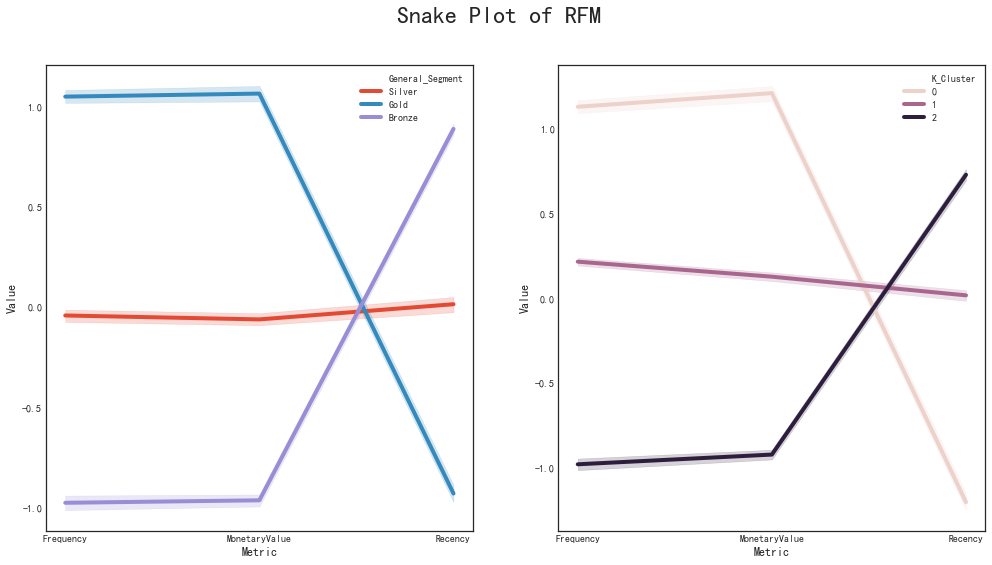

In [129]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 8))
sns.lineplot(x = 'Metric', y = 'Value', hue = 'General_Segment', data = rfm_melt,ax=ax1)

# K-Means的图
sns.lineplot(x = 'Metric', y = 'Value', hue = 'K_Cluster', data = rfm_melt,ax=ax2)
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号
plt.suptitle("Snake Plot of RFM",fontsize=24) 
plt.show()

In [130]:
# The further a ratio is from 0, the more important that attribute is for a segment relative to the total population
cluster_avg = rfm_rfm_k3.groupby(['K_Cluster']).mean()
population_avg = rfm_rfm.mean()
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
K_Cluster,,,
0,-0.86,1.87,2.20
1,-0.25,-0.28,-0.43
2,0.85,-0.84,-0.86


In [131]:
total_avg = rfm.iloc[:, 0:3].mean()
# calculate the proportional gap with total mean
cluster_avg = rfm.groupby('General_Segment').mean().iloc[:, 0:3]
prop_rfm = cluster_avg/total_avg - 1
prop_rfm.round(2)

,Recency,Frequency,MonetaryValue
General_Segment,,,
Bronze,1.08,-0.83,-0.87
Gold,-0.78,1.49,1.56
Silver,-0.22,-0.45,-0.48


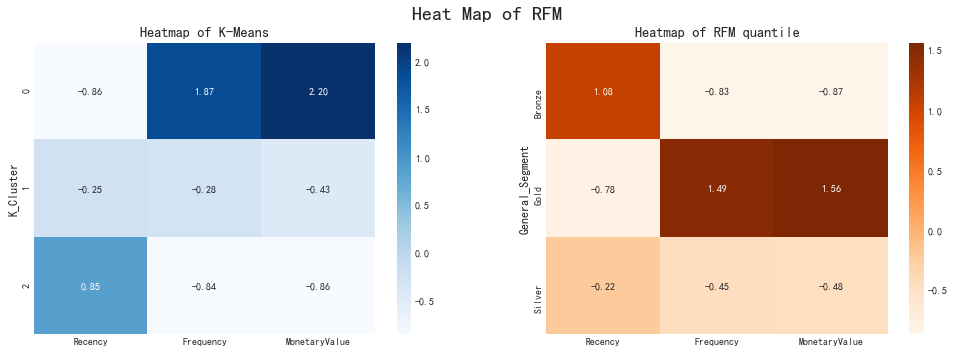

In [132]:
# RFM热力图
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='Blues',ax=ax1)
ax1.set(title = "Heatmap of K-Means")

#  K-Means
sns.heatmap(prop_rfm, cmap= 'Oranges', fmt= '.2f', annot = True,ax=ax2)
ax2.set(title = "Heatmap of RFM quantile")

plt.suptitle("Heat Map of RFM",fontsize=20) 

plt.show()